### Redes Neurais e Arquiteturas Profundas
#### **MBA em Ciências de Dados**


### *Módulo 3 - Arquiteturas de CNNS e treinamento de redes profundas*

**Parte 3 - Projetando blocos residuais e módulos inception**

Moacir A. Ponti - ICMC/USP

-

Biblioteca utilizada - Keras com Tensorflow

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from numpy.random import seed
from tensorflow.random import set_seed

In [2]:
# carregando datasets do keras
#from tensorflow.keras.datasets import mnist

from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

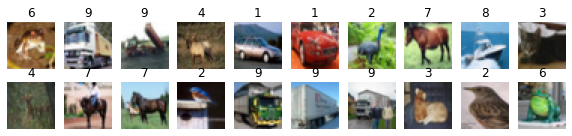

In [3]:
# visualizando 20 imagens do dataset
fig, axes = plt.subplots(2,10, figsize=(10,2))
ax = axes.ravel()
for i in range(20):
    ax[i].imshow(x_train[i], cmap="gray")
    ax[i].set_title("%d" % (y_train[i]))
    ax[i].axis('off')

In [4]:
# obtendo informações das imagens (resolucao) e dos rótulos (número de classes)
img_lin, img_col = x_train.shape[1], x_train.shape[2]
num_classes = len(np.unique(y_train))
print(x_train.shape)
print('Classes: ', num_classes)

(50000, 32, 32, 3)
Classes:  10


Pré-processando imagens

In [5]:
# dividir por 255 para obter normalizacao
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

print("Antes da transformação: ", y_train[0])
# transformar categorias em one-hot-encoding
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print("Após transformação: ", y_train[0])

Antes da transformação:  [6]
Após transformação:  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


Padronizar o formato de entrada

In [6]:
# verifica imagens da base de dados tem 3 canais (RGB) ou apenas 1 (escala de cinza)
if (len(x_train.shape) == 3):
      n_channels = 1
else:
      n_channels = x_train.shape[3]

# re-formata o array de forma a encontrar o formato da entrada (input_shape)
# se a dimensão dos canais vem primeiro ou após a imagem
if keras.backend.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], n_channels, img_lin, img_col)
    x_test = x_test.reshape(x_test.shape[0], n_channels, img_lin, img_col)
    input_shape = (n_channels, img_lin, img_col)
else:
    x_train = x_train.reshape(x_train.shape[0], img_lin, img_col, n_channels)
    x_test = x_test.reshape(x_test.shape[0], img_lin, img_col, n_channels)
    input_shape = (img_lin, img_col, n_channels)

print("Shape: ", input_shape)

Shape:  (32, 32, 3)


### 1) Arquitetura sequencial (estilo VGGNet)


In [7]:
VGGNet = keras.Sequential()
VGGNet.add(keras.layers.Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=input_shape))
VGGNet.add(keras.layers.Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
VGGNet.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
VGGNet.add(keras.layers.Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
VGGNet.add(keras.layers.Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
VGGNet.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
VGGNet.add(keras.layers.Conv2D(256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
VGGNet.add(keras.layers.Conv2D(256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
VGGNet.add(keras.layers.GlobalAveragePooling2D())
VGGNet.add(keras.layers.Dense(num_classes, activation='softmax'))
VGGNet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 256)         2

### 2) Arquitetura Inception (módulo V1)

In [8]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.utils import plot_model

In [9]:
def inception_module(layer_in, f1_out, f2_in, f2_out, f3_in, f3_out, f4_out):
    # 1x1 conv
    conv1 = Conv2D(f1_out, (1,1), padding='same', activation='relu')(layer_in)
    # 3x3 conv
    conv3 = Conv2D(f2_in, (1,1), padding='same', activation='relu')(layer_in)
    conv3 = Conv2D(f2_out, (3,3), padding='same', activation='relu')(conv3)
    # 5x5 conv
    conv5 = Conv2D(f3_in, (1,1), padding='same', activation='relu')(layer_in)
    conv5 = Conv2D(f3_out, (5,5), padding='same', activation='relu')(conv5)
    # 3x3 max pooling
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
    pool = Conv2D(f4_out, (1,1), padding='same', activation='relu')(pool)
    layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
    return layer_out
 
# definir entrada
input_layer = Input(shape=input_shape)
# adicionar módulos inception
layer = inception_module(input_layer, 64, 96, 128, 16, 32, 32)
pool = MaxPooling2D((2,2), strides=(2,2), padding='same')(layer) #
layer = inception_module(pool, 128, 128, 192, 32, 96, 64) # rem?
pool = MaxPooling2D((2,2), strides=(2,2), padding='same')(layer)
layer = inception_module(pool, 128, 128, 256, 32, 128, 64)
layer = inception_module(layer, 128, 128, 256, 32, 128, 64)
flatt = keras.layers.GlobalAveragePooling2D()(layer)

softmax = keras.layers.Dense(num_classes, activation='softmax')(flatt)

# cria modelo definindo camada de entrada e camada de saída
Inception = keras.models.Model(inputs=input_layer, outputs=softmax)
Inception.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 32, 32, 96)   384         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 32, 32, 16)   64          input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 32, 32, 3)    0           input_1[0][0]                    
_______________________________________________________________________________________

### 3) Arquitetura ResNet (bloco residual)


In [10]:
from tensorflow.keras.layers import add

# funcao que retorna um bloco residual
def residual_block(layer_in, n_filters):
    merge_input = layer_in
    #verifica se é necessária uma primeira camada para deixar o número de filtros iguais para adição
    if layer_in.shape[-1] != n_filters:
        merge_input = Conv2D(n_filters, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
    # conv1
    conv1 = Conv2D(n_filters, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
    # conv2
    conv2 = Conv2D(n_filters, (3,3), padding='same', activation='linear', kernel_initializer='he_normal')(conv1)
    # soma entrada com saída (pulou 2 camadas)
    layer_out = add([conv2, merge_input])
    # função de ativação da saída do bloco
    layer_out = keras.layers.Activation('relu')(layer_out)
    return layer_out
 

input_layer = Input(shape=input_shape)
layer1 = residual_block(input_layer, 64)
pool1 = MaxPooling2D((2,2), strides=(2,2), padding='same')(layer1)
layer2 = residual_block(pool1, 128)
pool2 = MaxPooling2D((2,2), strides=(2,2), padding='same')(layer2)
layer3 = residual_block(pool2, 256)
pool3 = MaxPooling2D((2,2), strides=(2,2), padding='same')(layer3)
flatt = keras.layers.GlobalAveragePooling2D()(pool3)
softmax = keras.layers.Dense(num_classes, activation='softmax')(flatt)

ResNet = keras.models.Model(inputs=input_layer, outputs=softmax)
ResNet.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 32, 32, 64)   1792        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 32, 32, 64)   36928       conv2d_31[0][0]                  
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 32, 32, 64)   256         input_2[0][0]                    
_______________________________________________________________________________________

In [11]:
x_sub = x_train[:5000]
y_sub = y_train[:5000]
batch_size = 64
epochs = 20

In [12]:
# as sementes ajudam a ter resultados reproduzíveis
seed(1)
set_seed(2)

VGGNet.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(lr=0.025, momentum=0.9),
              metrics=['accuracy'])

histVGG = VGGNet.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs, verbose=1)

Epoch 1/20
782/782 [==============================] - 23s 29ms/step - loss: 2.0056 - accuracy: 0.2491
Epoch 2/20
782/782 [==============================] - 22s 29ms/step - loss: 1.5542 - accuracy: 0.4238
Epoch 3/20
782/782 [==============================] - 22s 29ms/step - loss: 1.2928 - accuracy: 0.5312
Epoch 4/20
782/782 [==============================] - 22s 29ms/step - loss: 1.0625 - accuracy: 0.6208
Epoch 5/20
782/782 [==============================] - 23s 29ms/step - loss: 0.8737 - accuracy: 0.6890
Epoch 6/20
782/782 [==============================] - 22s 29ms/step - loss: 0.7208 - accuracy: 0.7476
Epoch 7/20
782/782 [==============================] - 22s 29ms/step - loss: 0.6076 - accuracy: 0.7889
Epoch 8/20
782/782 [==============================] - 22s 29ms/step - loss: 0.5268 - accuracy: 0.8161
Epoch 9/20
782/782 [==============================] - 22s 29ms/step - loss: 0.4492 - accuracy: 0.8437
Epoch 10/20
782/782 [==============================] - 22s 29ms/step - loss: 0.378

In [13]:
# as sementes ajudam a ter resultados reproduzíveis
#tf.keras.backend.clear_session()
seed(1)
set_seed(2)

Inception.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(lr=0.025, momentum=0.9),
              metrics=['accuracy'])

histInc = Inception.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs, verbose=1)

Epoch 1/20
782/782 [==============================] - 71s 91ms/step - loss: 1.8889 - accuracy: 0.2888
Epoch 2/20
782/782 [==============================] - 71s 91ms/step - loss: 1.4296 - accuracy: 0.4724
Epoch 3/20
782/782 [==============================] - 71s 90ms/step - loss: 1.1878 - accuracy: 0.5741
Epoch 4/20
782/782 [==============================] - 71s 91ms/step - loss: 1.0094 - accuracy: 0.6417
Epoch 5/20
782/782 [==============================] - 71s 90ms/step - loss: 0.8649 - accuracy: 0.6950
Epoch 6/20
782/782 [==============================] - 71s 91ms/step - loss: 0.7741 - accuracy: 0.7287
Epoch 7/20
782/782 [==============================] - 71s 90ms/step - loss: 0.6873 - accuracy: 0.7611
Epoch 8/20
782/782 [==============================] - 71s 90ms/step - loss: 0.6114 - accuracy: 0.7869
Epoch 9/20
782/782 [==============================] - 71s 91ms/step - loss: 0.5384 - accuracy: 0.8114
Epoch 10/20
782/782 [==============================] - 71s 90ms/step - loss: 0.484

In [14]:
# as sementes ajudam a ter resultados reproduzíveis
#tf.keras.backend.clear_session()
seed(1)
set_seed(2)

ResNet.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(lr=0.02, momentum=0.9),
              metrics=['accuracy'])

histResNet = ResNet.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs, verbose=1)

Epoch 1/20
782/782 [==============================] - 28s 36ms/step - loss: 1.8904 - accuracy: 0.2953
Epoch 2/20
782/782 [==============================] - 28s 36ms/step - loss: 1.2806 - accuracy: 0.5334
Epoch 3/20
782/782 [==============================] - 28s 36ms/step - loss: 1.0238 - accuracy: 0.6343
Epoch 4/20
782/782 [==============================] - 28s 36ms/step - loss: 0.8549 - accuracy: 0.6970
Epoch 5/20
782/782 [==============================] - 28s 36ms/step - loss: 0.7192 - accuracy: 0.7476
Epoch 6/20
782/782 [==============================] - 28s 36ms/step - loss: 0.6191 - accuracy: 0.7831
Epoch 7/20
782/782 [==============================] - 28s 36ms/step - loss: 0.5247 - accuracy: 0.8151
Epoch 8/20
782/782 [==============================] - 28s 36ms/step - loss: 0.4523 - accuracy: 0.8419
Epoch 9/20
782/782 [==============================] - 28s 36ms/step - loss: 0.3812 - accuracy: 0.8665
Epoch 10/20
782/782 [==============================] - 28s 36ms/step - loss: 0.312

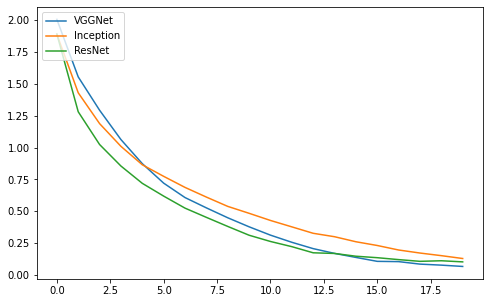

In [15]:
plt.figure(figsize=(8,5))
plt.plot(histVGG.history['loss'])
plt.plot(histInc.history['loss'])
plt.plot(histResNet.history['loss'])
plt.legend(["VGGNet", "Inception", "ResNet"], loc="upper left")

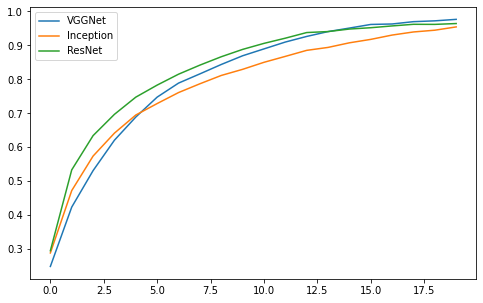

In [16]:
plt.figure(figsize=(8,5))
plt.plot(histVGG.history['accuracy'])
plt.plot(histInc.history['accuracy'])
plt.plot(histResNet.history['accuracy'])
plt.legend(["VGGNet", "Inception", "ResNet"], loc="upper left")

In [17]:
scoreV_Tr = VGGNet.evaluate(x_train, y_train, verbose = 0)
scoreV_Te = VGGNet.evaluate(x_test, y_test, verbose = 0)

scoreI_Tr = Inception.evaluate(x_train, y_train, verbose = 0)
scoreI_Te = Inception.evaluate(x_test, y_test, verbose = 0)

scoreR_Tr = ResNet.evaluate(x_train, y_train, verbose = 0)
scoreR_Te = ResNet.evaluate(x_test, y_test, verbose = 0)

In [18]:
print("VGG Acurácia treinamento: %.4f" % (scoreV_Tr[1]))
print("VGG Acurácia teste: %.4f" % (scoreV_Te[1]))

print("Inception Acurácia treinamento: %.4f" % (scoreI_Tr[1]))
print("Inception Acurácia teste: %.4f" % (scoreI_Te[1]))

print("ResNet Acurácia treinamento: %.4f" % (scoreR_Tr[1]))
print("ResNet Acurácia teste: %.4f" % (scoreR_Te[1]))

VGG Acurácia treinamento: 0.9794
VGG Acurácia teste: 0.8223
Inception Acurácia treinamento: 0.9537
Inception Acurácia teste: 0.8157
ResNet Acurácia treinamento: 0.9622
ResNet Acurácia teste: 0.7757
